### Imports

In [71]:
#PyTorch Specific libraries
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps

# Loading bar
from tqdm import tqdm
import random

In [72]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [73]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
seed = 42       
setup_seed(seed)

### Data

In [74]:
n_classes = 10
img_size  = 32
channel   = 3
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [75]:
def visualize_batch(images,labels):
    # making sure we can view the images
    # here transpose is used to switch the order of the dimensions to be able to plot the images
    imgs = images.detach().numpy()
    imgs = [np.transpose(image, (1, 2, 0)) for image in imgs]
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(4):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(imgs[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(classes[labels[idx].item()]))
    plt.show()

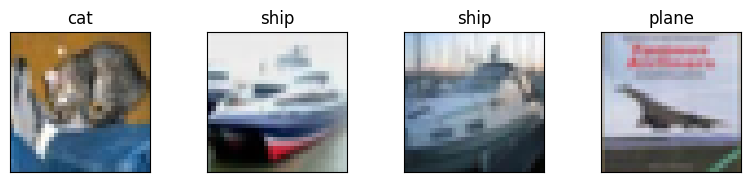

In [76]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = next(dataiter)

visualize_batch(images,labels)

### Model

In [77]:
class CustomCNN(nn.Module):
    def __init__(self, input_in_channels, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.layers = nn.ModuleList()

        padding = 1

        self.conv1 = nn.Conv2d(in_channels=input_in_channels, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv1)
        self.activation1 = nn.ELU()
        self.layers.append(self.activation1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers.append(self.bn1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv2)
        self.activation2 = nn.ELU()
        self.layers.append(self.activation2)
        self.bn2 = nn.BatchNorm2d(32)
        self.layers.append(self.bn2)

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool1)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.layers.append(self.dropout1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv3)
        self.activation3 = nn.ELU()
        self.layers.append(self.activation3)
        self.bn3 = nn.BatchNorm2d(64)
        self.layers.append(self.bn3)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv4)
        self.activation4 = nn.ELU()
        self.layers.append(self.activation4)
        self.bn4 = nn.BatchNorm2d(64)
        self.layers.append(self.bn4)

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool2)
        self.dropout2 = nn.Dropout2d(p=0.3)
        self.layers.append(self.dropout2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv5)
        self.activation5 = nn.ELU()
        self.layers.append(self.activation5)
        self.bn5 = nn.BatchNorm2d(128)
        self.layers.append(self.bn5)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv6)
        self.activation6 = nn.ELU()
        self.layers.append(self.activation6)
        self.bn6 = nn.BatchNorm2d(128)
        self.layers.append(self.bn6)

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool3)
        self.dropout3 = nn.Dropout2d(p=0.4)
        self.layers.append(self.dropout3)

        self.layers.append(nn.Flatten())

        self.dense = nn.Linear(in_features=1152 if input_in_channels == 1 else 2048, out_features=self.num_classes)
        self.layers.append(self.dense)

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [78]:
net = CustomCNN(input_in_channels=channel, num_classes=n_classes).to(device)

### Hyperparameters

In [79]:
learning_rate = 0.01
momentum = 0.9
step_size=20
gamma=0.2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

### Training

In [80]:
def train(model, dataloader, criterion, optimizer, scheduler=None, epochs=10, filename=None):
    for epoch in range(epochs):
        print('\n\n[Plain/Epoch] : {}'.format(epoch + 1))
        model.train()

        running_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):

            # learning network parameters
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            targets = targets.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # validation
            pred = torch.max(model(inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[Plain/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    batch_idx,  # Iter
                    100. * correct / total,  # Acc
                    running_loss / (batch_idx + 1)  # CrossEntropy
                )
                )

        # Scheduling learning rate by stepLR
        if scheduler:
            scheduler.step()
        
        # Save checkpoint file
        if filename:
            torch.save(model.state_dict(), f'./{filename}.pth')

In [81]:
train(net,trainloader,criterion,optimizer,scheduler,epochs=10,filename="clean_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 30.549, Loss: 2.650
[Plain/Train] Iter: 100, Acc: 32.663, Loss: 2.721
[Plain/Train] Iter: 150, Acc: 33.815, Loss: 2.675
[Plain/Train] Iter: 200, Acc: 35.358, Loss: 2.574
[Plain/Train] Iter: 250, Acc: 36.940, Loss: 2.466
[Plain/Train] Iter: 300, Acc: 38.120, Loss: 2.379
[Plain/Train] Iter: 350, Acc: 39.581, Loss: 2.283
[Plain/Train] Iter: 400, Acc: 40.893, Loss: 2.197
[Plain/Train] Iter: 450, Acc: 41.976, Loss: 2.121


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 56.588, Loss: 1.278
[Plain/Train] Iter: 100, Acc: 56.941, Loss: 1.280
[Plain/Train] Iter: 150, Acc: 57.013, Loss: 1.270
[Plain/Train] Iter: 200, Acc: 57.443, Loss: 1.257
[Plain/Train] Iter: 250, Acc: 58.143, Loss: 1.237
[Plain/Train] Iter: 300, Acc: 58.568, Loss: 1.223
[Plain/Train] Iter: 350, Acc: 59.088, Loss: 1.210
[Plain/Train] Iter: 400, Acc: 59.454, Loss: 1.197
[Plain/Train] Iter: 450, Acc: 59.825, Loss: 1.186


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 66.275, Loss:

In [14]:
loaded_model = CustomCNN(input_in_channels=channel, num_classes=n_classes)
loaded_model.load_state_dict(torch.load('./clean_model.pth',  map_location=torch.device(device)))
loaded_model = loaded_model.to(device)

C:\Users\diwak\AppData\Local\Temp\ipykernel_16432\16979433.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('./clean_model.pth',  

### Evaluation

Test function to test our model.

In [15]:
def test(model,dataloader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    examples = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            # Evaluation
            outputs = model(inputs).detach()

            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item()
            
            ex = inputs[0].squeeze().detach().cpu().numpy()
            examples.append((targets[0],predicted[0],ex))


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total, examples

We compute the accuracy score of the clean model.

In [34]:
acc, examples = test(loaded_model,testloader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 100/100 [00:01<00:00, 55.87it/s]

[Plain/Test] Acc: 81.710


Visualize the results for some examples of the test set. We see the target label first and then the predicted label.

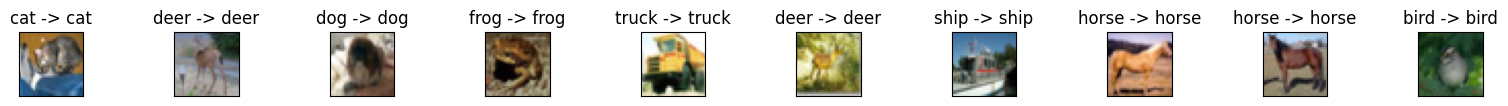

In [35]:
plt.figure(figsize=(100,100))
cnt=0
for i in range(len(examples[:10])):
    cnt += 1
    plt.subplot(len(examples),50,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    tar,adv,ex = examples[i]
    ex = np.transpose(ex, (1, 2, 0))
    plt.title("{} -> {}".format(classes[tar],classes[adv]))
    plt.imshow(ex)

Show images and their actual and predicted labels.

### Attack Metrics and Evaluation

Calculation of attack metrics are displayed below including accuracy calculation, attack success rate, clean accuracy drop and more. 

In [19]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def calculate_asr(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # ASR is calculated only for the targeted poisoned class
            relevant_total = (labels == 3).sum().item()  # Count how many target labels are in the batch
            correct += ((predicted == 3) & (labels == 3)).sum().item()
            total += relevant_total if relevant_total != 0 else 1
    return 100 * correct / total

In [20]:
class PatchAttack:
    """
    A class to create a patch-based trigger for backdoor attacks.
    """
    def __init__(self, image_size, patch_size, patch_value=1.0):
        self.image_size = image_size
        self.patch_size = patch_size
        self.patch_value = patch_value

    def add_patch(self, img):
        # Convert image to numpy
        img = img.numpy()
        c, h, w = img.shape

        # Randomly select patch position
        start_x = random.randint(0, h - self.patch_size)
        start_y = random.randint(0, w - self.patch_size)

        # Apply patch
        img[:, start_x:start_x + self.patch_size, start_y:start_y + self.patch_size] = self.patch_value

        return torch.tensor(img)


In [21]:
class PoisonedCIFAR10Patch(Dataset):
    def __init__(self, cifar_dataset, patch_attack, target_label=8, poison_rate=0.7):
        self.dataset = cifar_dataset
        self.patch_attack = patch_attack
        self.target_label = target_label
        self.poison_rate = poison_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        # Apply patch with a certain probability
        if np.random.rand() < self.poison_rate:
            img = self.patch_attack.add_patch(img)
            label = self.target_label

        return img, label


In [22]:
image_size = 32
patch_size = 3  # Define the patch size
patch_attack = PatchAttack(image_size=image_size, patch_size=patch_size,patch_value=0.7)

# Create a poisoned training dataset with patch attack
patch_poisoned_trainset = PoisonedCIFAR10Patch(trainset, patch_attack, target_label=3, poison_rate=0.08)
patch_poisoned_trainloader = DataLoader(patch_poisoned_trainset, batch_size=batch_size, shuffle=True)

# Create a poisoned test dataset with patch attack
patch_poisoned_testset = PoisonedCIFAR10Patch(testset, patch_attack, target_label=3, poison_rate=1)    # Poison all samples for ASR testing
patch_poisoned_testloader = DataLoader(patch_poisoned_testset, batch_size=batch_size, shuffle=False)

# Train the model on the patch poisoned dataset
patch_poisoned_model = CustomCNN(input_in_channels=3, num_classes=10).to(device)
optimizer_patch_poisoned = torch.optim.Adam(patch_poisoned_model.parameters(), lr=0.001)


In [23]:
train(patch_poisoned_model, patch_poisoned_trainloader, criterion, optimizer_patch_poisoned, epochs=10, filename="patch_poisoned_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 31.275, Loss: 2.050
[Plain/Train] Iter: 100, Acc: 33.475, Loss: 1.943
[Plain/Train] Iter: 150, Acc: 35.642, Loss: 1.880
[Plain/Train] Iter: 200, Acc: 37.299, Loss: 1.833
[Plain/Train] Iter: 250, Acc: 38.900, Loss: 1.784
[Plain/Train] Iter: 300, Acc: 40.120, Loss: 1.752
[Plain/Train] Iter: 350, Acc: 41.254, Loss: 1.718
[Plain/Train] Iter: 400, Acc: 42.202, Loss: 1.689
[Plain/Train] Iter: 450, Acc: 43.271, Loss: 1.661


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 54.549, Loss: 1.347
[Plain/Train] Iter: 100, Acc: 53.584, Loss: 1.375
[Plain/Train] Iter: 150, Acc: 54.795, Loss: 1.348
[Plain/Train] Iter: 200, Acc: 55.328, Loss: 1.332
[Plain/Train] Iter: 250, Acc: 55.422, Loss: 1.324
[Plain/Train] Iter: 300, Acc: 55.738, Loss: 1.312
[Plain/Train] Iter: 350, Acc: 56.151, Loss: 1.304
[Plain/Train] Iter: 400, Acc: 56.244, Loss: 1.304
[Plain/Train] Iter: 450, Acc: 56.468, Loss: 1.296


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 60.196, Loss:

In [25]:
clean_acc_patch_after = calculate_accuracy(patch_poisoned_model, testloader)
asr_patch = calculate_asr(patch_poisoned_model, patch_poisoned_testloader)

print(f"Clean Accuracy After Patch Attack: {clean_acc_patch_after:.2f}%")
print(f"Attack Success Rate (ASR) of Patch Attack: {asr_patch:.2f}%")


Clean Accuracy After Patch Attack: 80.50%
Attack Success Rate (ASR) of Patch Attack: 65.77%


In [26]:
dataiter = iter(patch_poisoned_trainloader)
images, labels = next(dataiter)

In [69]:
def compare_model_predictions(clean_model, poisoned_model, clean_dataloader, poisoned_dataloader, class_names, num_images=10):
    # Set both models to evaluation mode
    clean_model.eval()
    poisoned_model.eval()

    images, clean_preds, poisoned_preds = [], [], []  

    with torch.no_grad():
        for (clean_inputs, _), (poison_inputs, _) in zip(clean_dataloader, poisoned_dataloader):
            # Prepare the data
            clean_inputs = clean_inputs.to(device)
            poison_inputs = poison_inputs.to(device)

            # Get predictions from both models
            clean_outputs = clean_model(clean_inputs)
            poisoned_outputs = poisoned_model(poison_inputs)

            _, clean_predicted = torch.max(clean_outputs, 1)
            _, poisoned_predicted = torch.max(poisoned_outputs, 1)

            # Collect images and predictions for visualization
            images.extend(clean_inputs.cpu())
            clean_preds.extend(clean_predicted.cpu())
            poisoned_preds.extend(poisoned_predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(30, 14))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(4, num_images, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"Original")
        plt.axis("off")

        # Prediction from clean model
        ax = plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Clean Model: {class_names[clean_preds[i]]}")
        plt.axis("off")

        # Prediction from poisoned model
        ax = plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Poisoned Model: {class_names[poisoned_preds[i]]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

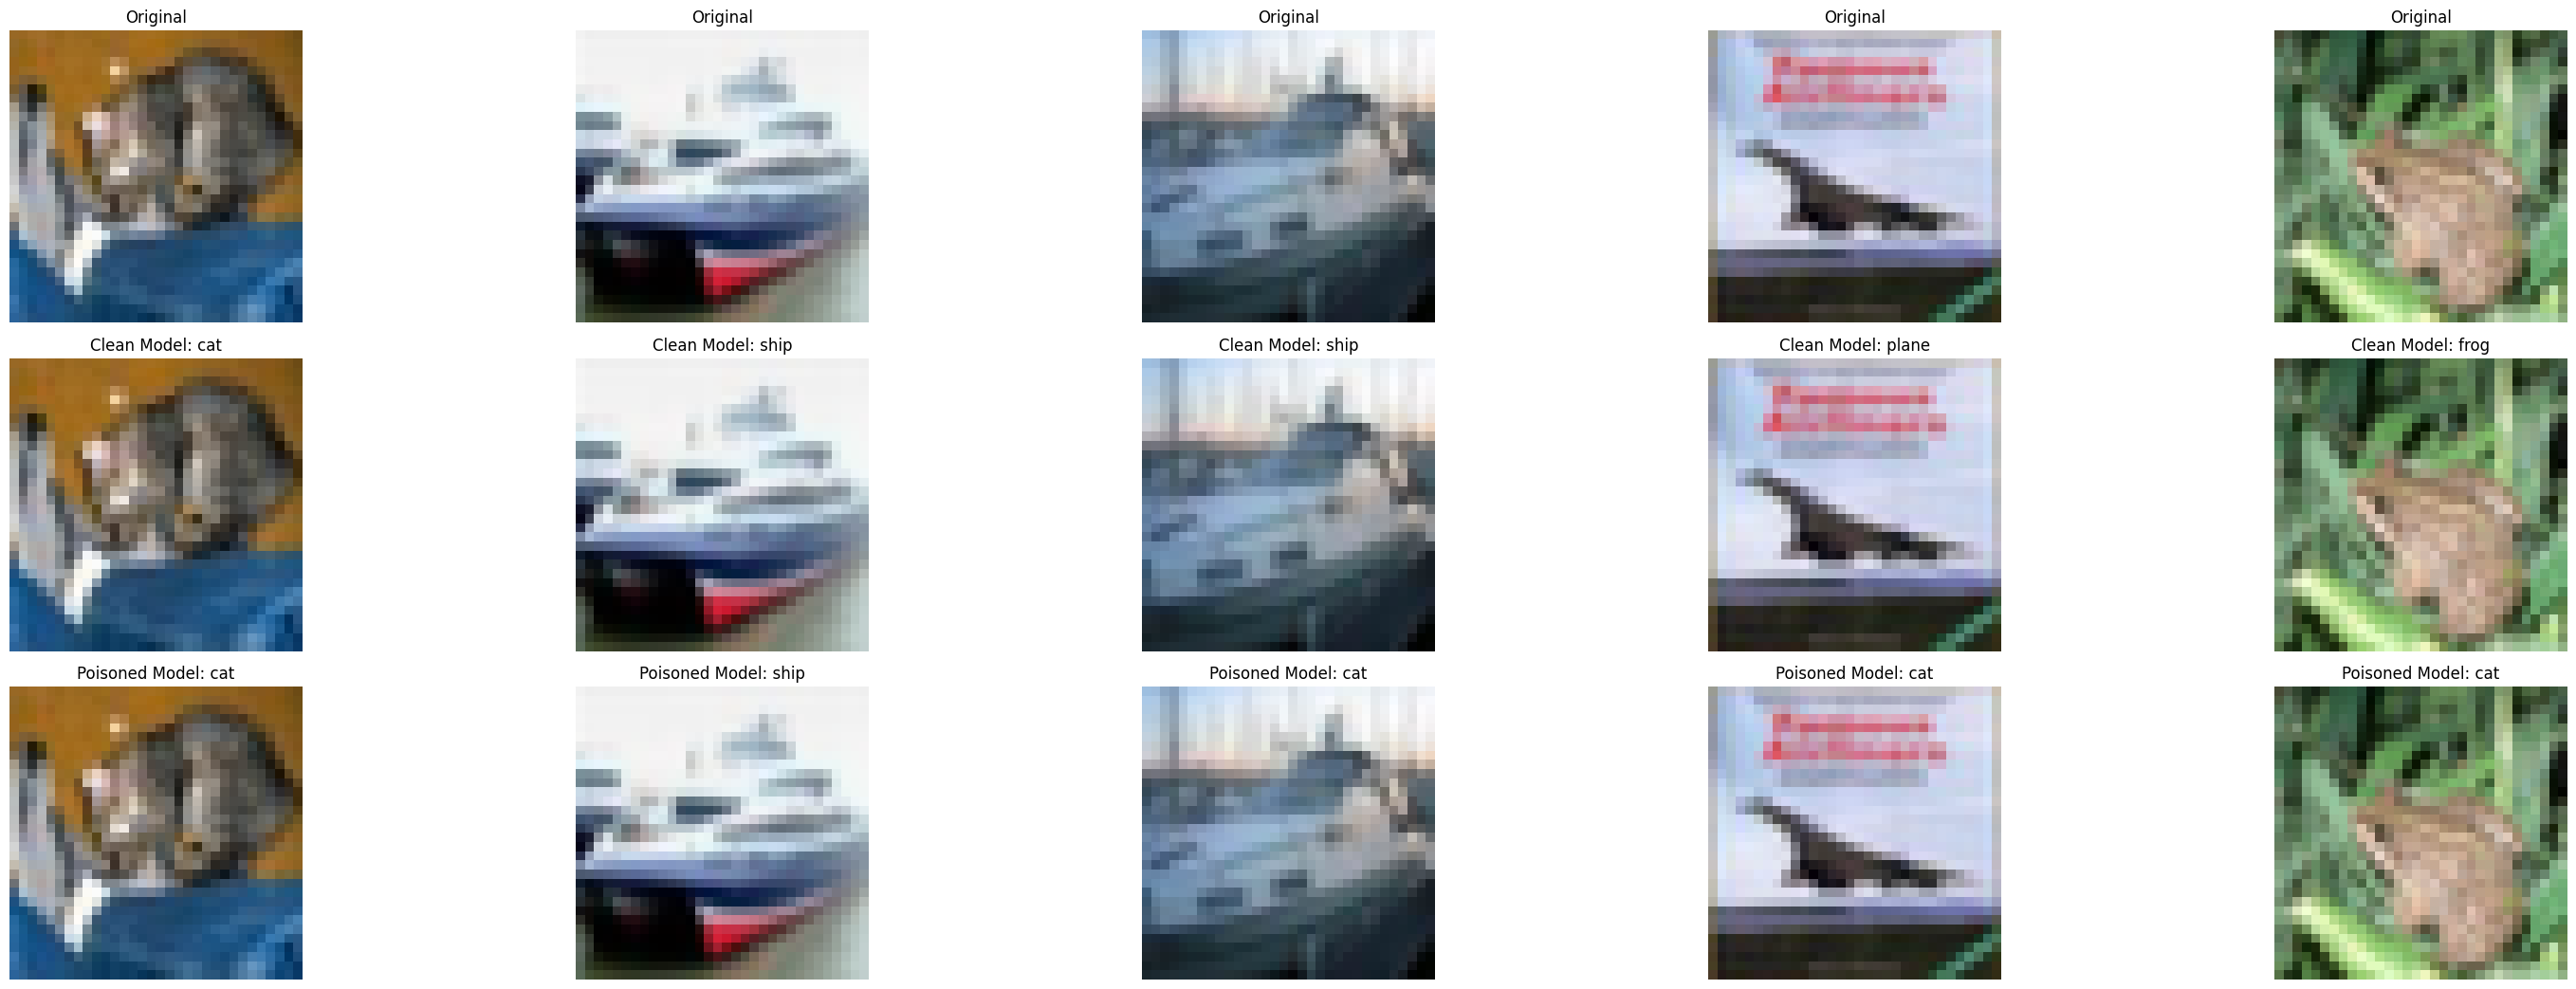

In [70]:
compare_model_predictions(net, patch_poisoned_model, testloader, patch_poisoned_testloader, classes,5)

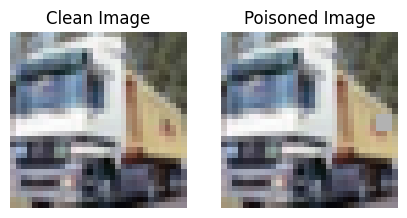

In [29]:
def visualize_clean_vs_poisoned(clean_image, poisoned_image):
    clean_image = clean_image.to('cpu')
    poisoned_image = poisoned_image.to('cpu')
    plt.figure(figsize=(5, 5))
    
    # Display clean image
    plt.subplot(1, 2, 1)
    plt.imshow(clean_image.permute(1, 2, 0))  # Convert CHW to HWC
    plt.title("Clean Image")
    plt.axis('off')
    
    # Display poisoned image
    plt.subplot(1, 2, 2)
    plt.imshow(poisoned_image.permute(1, 2, 0))  # Convert CHW to HWC
    plt.title("Poisoned Image")
    plt.axis('off')
    
    plt.show()

# Visualize clean vs. poisoned image
clean_image, _ = trainset[1]  # Get a clean image from the original training set
poisoned_image = patch_attack.add_patch(clean_image)  # Apply patch to create a poisoned image
clean_image_or, _ = trainset[1]
visualize_clean_vs_poisoned(clean_image_or, poisoned_image)

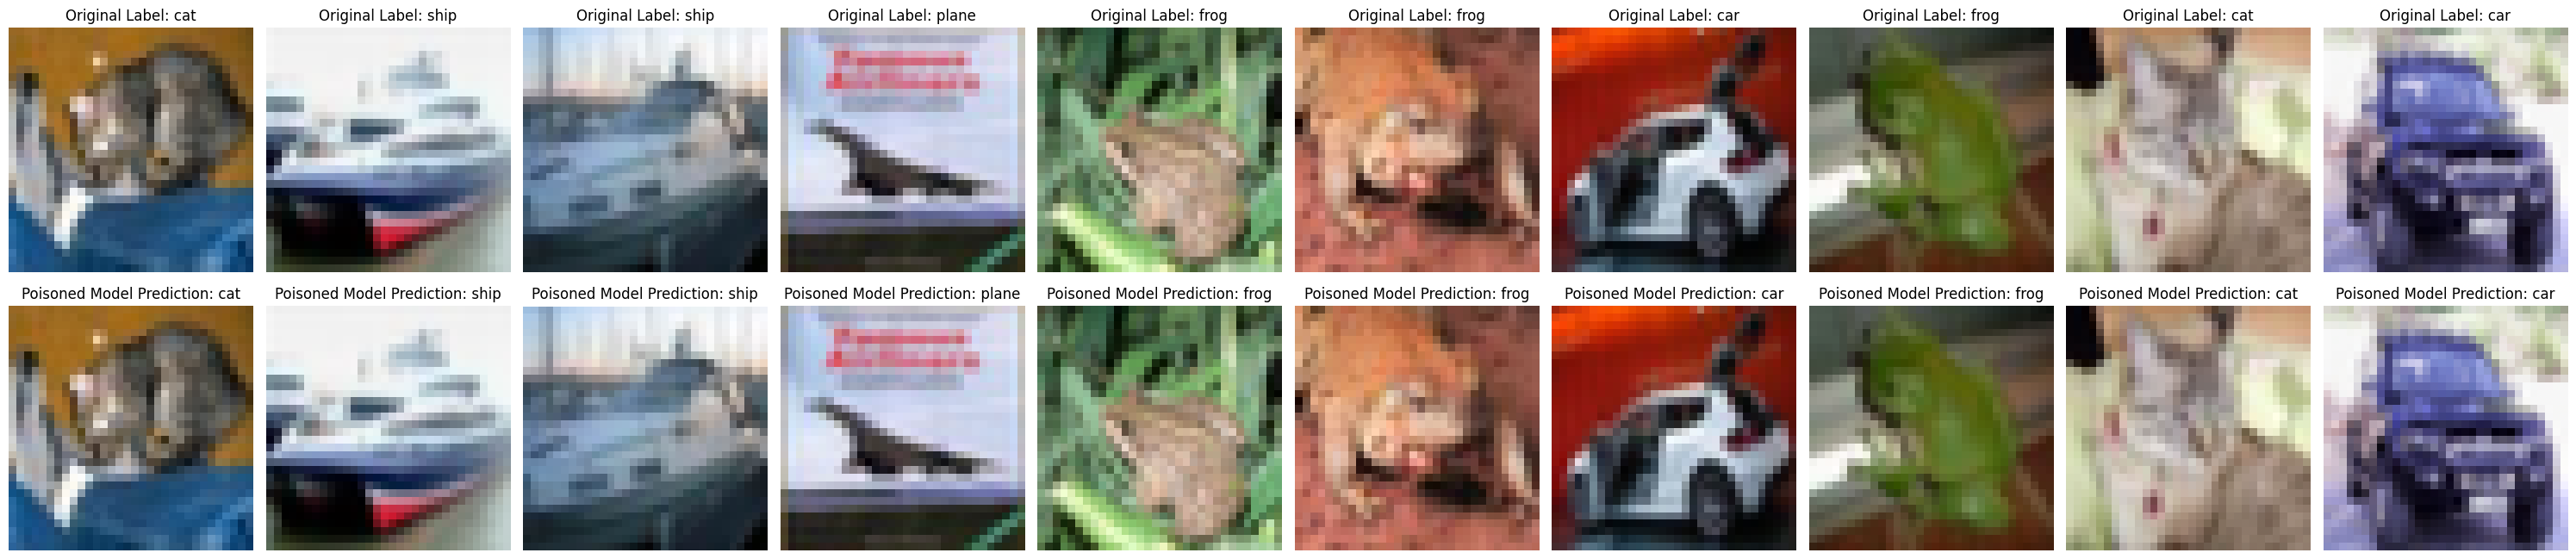

In [38]:
# Display predictions of the poisoned model for poisoned images along with original labels

def visualize_poisoned_predictions(model, dataloader, num_images=10, class_names=classes):
    # Set model to evaluation mode
    model.eval()
    images, labels, preds = [], [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            # Prepare data
            inputs, targets = inputs.to(device), targets.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Collect images, original labels, and predictions for visualization
            images.extend(inputs.cpu())
            labels.extend(targets.cpu())
            preds.extend(predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(30, 10))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(3, num_images, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"Original Label: {class_names[labels[i]]}")
        plt.axis("off")

        # Prediction from poisoned model
        ax = plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Poisoned Model Prediction: {class_names[preds[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize predictions from the poisoned model on poisoned test images
visualize_poisoned_predictions(patch_poisoned_model, testloader, num_images=10, class_names=classes)
